In [1]:
import JSON
using Plots
using HDF5
using SparseArrays
using IterativeSolvers
using LinearAlgebra
using Statistics
include("tools.jl")
include("get_grid.jl")

get_grid (generic function with 1 method)

In [2]:
border = Float64.([-100 -100; -100 200; 100 200; 100 -100; -100 -100])
println(size(border))
dx = 5
kk = 1
dxs = vec([50,25, 20, 10, 5, ])
values = zeros(length(dxs),10)
for dx = dxs

    Nx, Ny, xrange, yrange, isgrid, isborder, n = get_grid(border, Float64(dx))

    id_xy = findall(isgrid)
    id_x = Int64.(zeros(length(id_xy)))
    id_y = Int64.(zeros(length(id_xy)))
    for i in 1:length(id_xy)
        id_y[i] = id_xy[i][1]
        id_x[i] = id_xy[i][2]
    end

    Nbus = length(id_x)

    # get the list of edges and susceptance vector
    epsilon = Int64.(zeros(Int64(1E6),2))
    b = zeros(Int64(1E6))
    k = 1

    for i=1:length(id_x)
        if(isgrid[id_y[i], id_x[i]+1])
            id = findall((id_y .== id_y[i]) .& (id_x .== (id_x[i]+1)))
            epsilon[k,:] = [i id]
            b[k] = 1
            k += 1
        end
        if(isgrid[id_y[i]+1, id_x[i]])
            id = findall((id_y .== (id_y[i]+1)) .& (id_x .== id_x[i]))
            epsilon[k,:] = [i id]
            b[k] = 1
            k += 1
        end
    end
    
    N = k-1
    epsilon = epsilon[1:N,:]
    b = b[1:N]
    #println(b)
    
    B = sparse([epsilon[:,1];epsilon[:,2]],[1:N; 1:N],[-ones(N); ones(N)])
    Db = sparse(1:N, 1:N, b)
    L = B * Db * B'
    @time begin
        eig = eigen(Array{Float64,2}(L))
        V_ref = eig.vectors
        D_ref = eig.values;
    end
    values[kk,:] = D_ref[2:11]
    global kk += 1
end

(5, 2)
  0.005302 seconds (12 allocations: 27.969 KiB)
  0.005707 seconds (16 allocations: 324.250 KiB)
  0.008973 seconds (16 allocations: 759.500 KiB)
  0.121130 seconds (16 allocations: 11.202 MiB)
  2.957012 seconds (19 allocations: 176.643 MiB, 0.51% gc time)


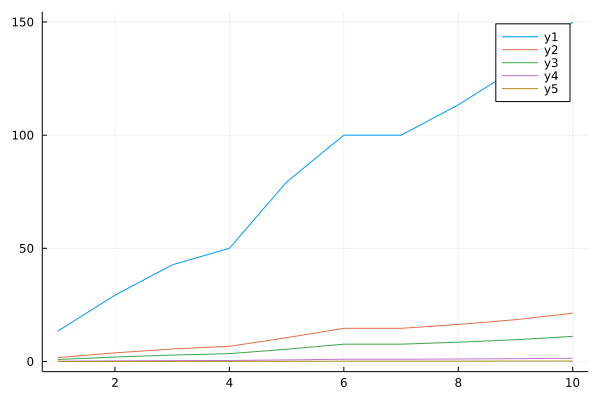

In [6]:
# v = sparse(1:length(dxs), 1:length(dxs), dxs.^(-2))*values
#v = sparse(1:length(dxs), 1:length(dxs), dxs.^(-1))*values
#v = values
v = sparse(1:length(dxs), 1:length(dxs), dxs)*values
#v = sparse(1:length(dxs), 1:length(dxs), dxs.^(2))*values
plot(v')
#plot!(xlims=(0,Inf), ylims=(0,1))